# From Statistical Physics to Data-Driven Modelling with Applications to Quantitative Biology

Tutorial 4. Sparse estimation techniques for alternative splicing in gene expression.

Artificial data generated by the authors.

Solution Notebook SC RM FZ.





In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import numpy.matlib
from random import randint
from sklearn import linear_model
#Pip3 install sklearn 
%matplotlib inline
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["mathtext.fontset"] = "dejavuserif"
#plt.rcParams["figure.figsize"] = (10, 8)
#plt.rcParams["font.size"] = 24

Read data for the overlapping and nonoverlapping reads.

In [15]:
useoverlap=False

#L= fixed number of exons in a gene
L=10
#ttl= Total number of possible transcripts 
ttL=2**L


if (useoverlap):
    y=np.loadtxt('../Data/dataNe2Nt5.dat',dtype=int)
else:
    y=np.loadtxt('../Data/dataNe2Nt5-nooverlap.dat',dtype=int)
print(y)

#Original set of transcripts and their corresponding expressions
thetaread=np.loadtxt('../Data/transcriptscpnbNe2Nt5.dat',dtype=int)
Nt=np.size(thetaread,0)
theta=np.zeros(ttL-1,dtype=int)



[671 344  26  40 671   0   0 275  26   0]


Write down the transcript matrix A.

In [16]:
#Function to define the ranscript matrix A both in the non-overlapping case and in the overlapping case

def Amatrix (overlap):
    if (overlap):
        Lp=int(L*(L+1)/2.)
    else:
        Lp=L
    Ar=np.zeros((Lp,2**L-1)).astype(int)
    for i in range(2**L-1):
        for j in range(L):
            Ar[j,i]=(i+1)>>j&1
        if (overlap):
            rpart=Ar[:,i]
            #locate the ones in the vector
            ind=np.where(rpart==1)[0].astype(int)
            nb1=np.size(ind)
            #put the ones for the junctions
            for ii in range (nb1-1):
                xi=ind[ii]
                xj=ind[ii+1]
                ip=( -np.power(xi,2)/2+xj+xi*(-3/2+L) ).astype(int)
                Ar[L+ip-1,i]=1
    return Ar

#Build the matrix A
A = Amatrix(useoverlap)


In [18]:
#Check on real numbers of transcript that the linear relationship is verified
for i in range(Nt):
    theta[thetaread[i,0]]=thetaread[i,1]
print(coo_matrix(theta))
ytest = np.dot(A,theta)
print(ytest)

  (0, 7)	14
  (0, 16)	327
  (0, 18)	344
  (0, 127)	275
  (0, 267)	26
[671 344  26  40 671   0   0 275  26   0]


Question 1: Program the Lasso routine to find the minimum of 1/(2L) (y - P θ)^2 + γ |θ|. 




In [19]:
def mylasso(P,y,gamma):
    #Rephrase problem as 1/2 theta X theta - z theta + gamma |theta|
    ll=np.size(y)
    X = np.dot(P.T,P)/ll
    z = np.dot(P.T,y)/ll
    nn=np.size(z)
    eps=0.00001
    diffla=eps+1.
    theta=np.zeros(nn)
    #random iteration over all variables
    while (diffla > eps):
        thetaold=np.copy(theta)  
        for j in range (nn):
            theta[j]=0
            xv=X[j,:];
            vvar=z[j]-np.dot(theta,xv.T);        # version with |theta| instead of theta>0
            if (vvar>gamma):                    # abs(vvar)>gamma
                theta[j]=(vvar-gamma)/(X[j,j])   # (vvar-np.sign(vvar)*gamma)/(X[j,j])
        diffla=max(abs(theta-thetaold));
    return theta



Compare with the Lasso routine in Python.

In [20]:
#Lasso routine in Python.
def mylasso_python(P,y,gamma):
    clf = linear_model.Lasso(alpha=gamma,positive=True,fit_intercept=False,max_iter=100000)
    clf.fit(P, y) 
    return clf.coef_

In [21]:
# Test of mylasso

PP=np.array([[1,2,3],[4,3,2]])
ThTh=np.array([1,0,0])
YY=np.dot(PP,ThTh)
myalpha=1
ThThi=mylasso(PP,YY,myalpha)
lc=sum(np.square(YY-np.dot(PP,ThThi)))/(2*np.size(YY))+myalpha*sum(ThThi)
print('mylasso final:',lc,coo_matrix(ThThi))
clf = linear_model.Lasso(alpha=myalpha,positive=True,fit_intercept=False)
clf.fit(PP, YY) 
lc=sum(np.square(YY-np.dot(PP,clf.coef_)))/(2*np.size(YY))+myalpha*sum(clf.coef_)
print('lasso:',lc,clf.sparse_coef_)


mylasso final: 0.9411764705882353   (0, 0)	0.8823529411764706
lasso: 0.9411764705882353   (0, 0)	0.8823529411764706


Question 2: Discuss the solutions for θ given by the Lasso algorithm for some values of γ = 0.01, 0.1, 1, and compare to the real vector θ.

Non zero elements: 33
True transcripts: [  7  16  18 127 267]
Predicted transcripts: [ 16 143   2  18 144  17 130 146 402  10]
Matches: {16, 18}
True positive rate: 0.2
True expressions: [14, 327, 344, 275, 26]
Predicted expressions: [313.53598405 102.95125226  80.42635563  77.08987558  59.4446856
  38.3658903   36.46802517  27.37246928  16.57503624  12.01557292]
Inferred vector theta: 
   (0, 2)	80.42635563454799
  (0, 6)	9.479166666707618
  (0, 10)	12.015572916680656
  (0, 14)	4.7395833333220825
  (0, 16)	313.5359840514846
  (0, 17)	38.36589030316206
  (0, 18)	77.08987558358355
  (0, 22)	3.554687499986365
  (0, 26)	6.896458333333426
  (0, 30)	2.13281249999877
  (0, 130)	36.46802517334439
  (0, 134)	2.1328124999900693
  (0, 138)	5.705546874998342
  (0, 142)	1.2796875000005716
  (0, 143)	102.95125225758865
  (0, 144)	59.444685597671786
  (0, 145)	8.295244659750717
  (0, 146)	27.372469277331398
  (0, 150)	1.0237499999955897
  (0, 154)	3.628078124998795
  (0, 158)	0.682500000000439
  (0,

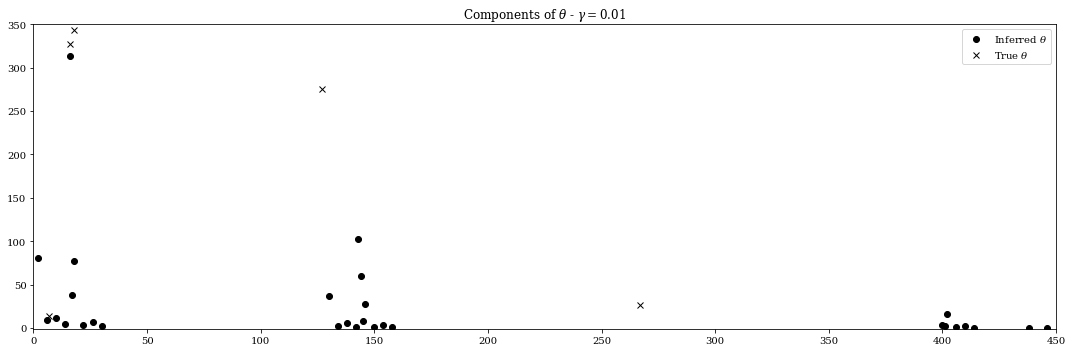

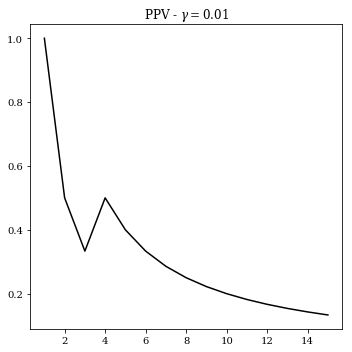

In [25]:
# Question 2: Data analysis for a single gamma

mygamma=0.01
thetainf=mylasso_python(A,y,mygamma)
#thetainf=mylasso(A,y,mygamma)
Nmax=np.count_nonzero(thetainf)
print('Non zero elements:',Nmax)
thetatrue=np.nonzero(theta)[0]
thetainfsort=np.sort(thetainf)[::-1]
thetainfsort_index=np.argsort(thetainf)[::-1]
Npred=min(2*Nt,Nmax)
predict=thetainfsort_index[0:Npred]
numbers=thetainfsort[0:Npred]
print('True transcripts:', thetatrue)
print('Predicted transcripts:', predict)
a=set(thetatrue) & set(predict)
print('Matches:',a)
print('True positive rate:', len(a)/(2*Nt))
thetatrueval=[theta[i] for i in thetatrue]
print('True expressions:',thetatrueval)
print('Predicted expressions:',numbers)
print('Inferred vector theta: \n',coo_matrix(thetainf))

ris = np.zeros((15,2))
for i in range(15):
    predict=thetainfsort_index[0:i+1]
    ris[i,0]=i+1
    ris[i,1]=len(set(thetatrue) & set(predict))/(i+1)

#plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))
#plt.stem(thetainf, label=r'Inferred $\theta$')
plt.plot(np.argwhere(thetainf), thetainf[thetainf != 0], 'ko', label=r'Inferred $\theta$')
plt.plot(np.argwhere(theta), theta[theta != 0], 'kx', label=r'True $\theta$')
plt.axis([0,450,-1,350])
plt.title('Components of $\\theta$ - $\\gamma = %.2f$' % mygamma)
#plt.text(420, 180, 'E', fontweight='bold')
plt.tight_layout()
plt.legend()
#plt.savefig('gamma_1e-0_th_nooverlap.pdf')    
#plt.savefig('gamma_1e-0_th_overlap.pdf')    

plt.figure(figsize=(5, 5))
plt.plot(ris[:,0],ris[:,1],'k')
plt.title('PPV - $\\gamma = %.2f$' % mygamma)
#plt.text(14, 0.9, 'F', fontweight='bold')
plt.tight_layout()
#plt.savefig('gamma_1e-0_PPV_nooverlap.pdf')
#plt.savefig('gamma_1e-0_PPV_overlap.pdf')

Question 4: Study the performances of the Lasso algorithm as a function of γ .
Plot the Mean Square Error as a function of γ, plot the quadratic cost function of the solution θ as a function  as a function of γ, and the total number of of non-zero elements of θ as a function of γ for the 5 transcripts corresponding to the true transcripts (t = 7, 16, 18, 127, 267).

Optimal value of gamma: 0.01291549665014884


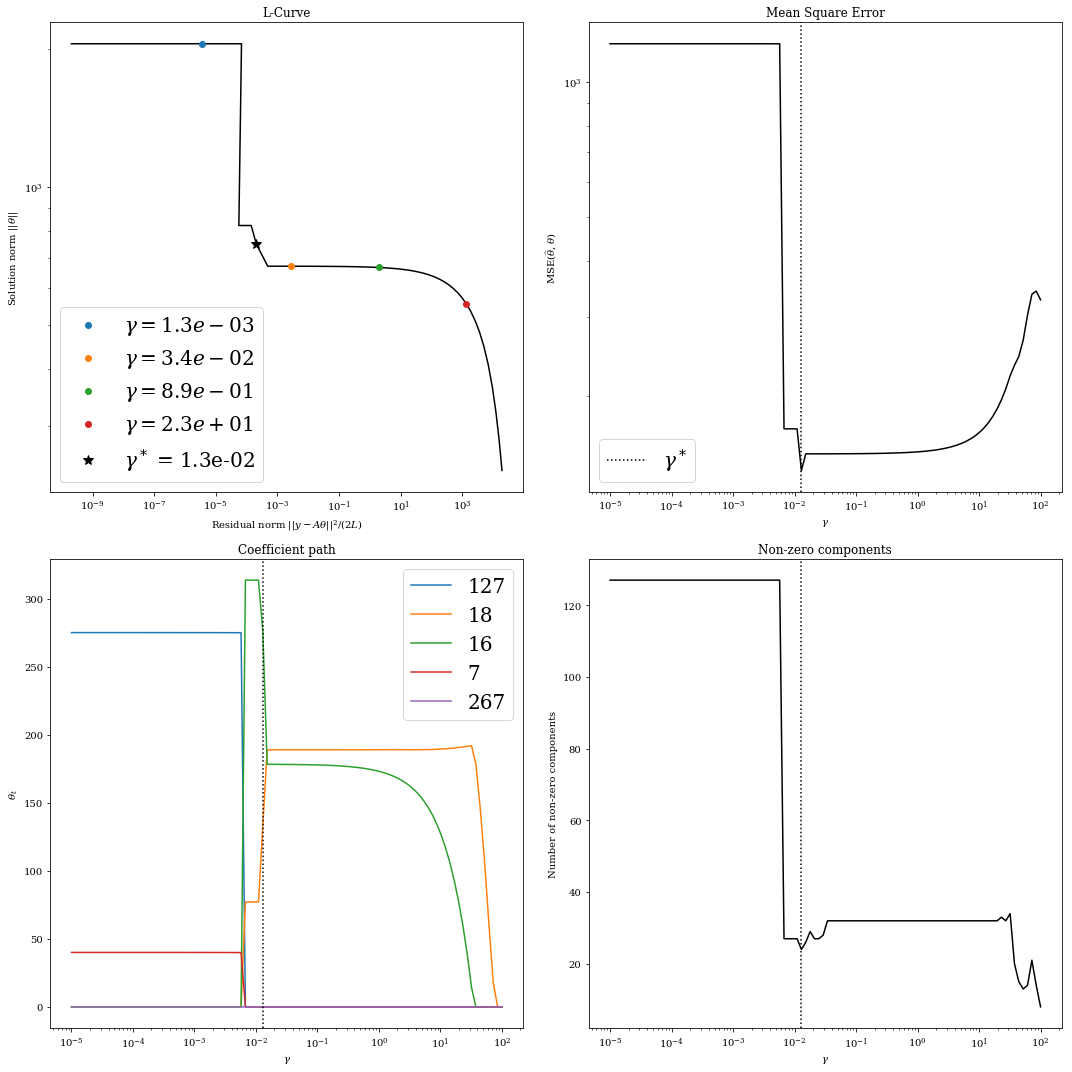

In [27]:


gam_dom = np.logspace(-5, 2, 100)

rss = np.zeros(len(gam_dom))
reg = np.zeros(len(gam_dom))
mse = np.zeros(len(gam_dom))
nonz = np.zeros(len(gam_dom))
d = np.zeros((len(gam_dom),Nt))


# Compute different metrics for many $\gamma$
for (i, gam) in enumerate(gam_dom):
    thetainf=mylasso_python(A,y,gam)

    rss[i] = np.mean((y - np.dot(A,thetainf)) ** 2)/2
    reg[i] = np.sum(np.abs(thetainf))
    mse[i] = np.mean((theta - thetainf) ** 2)
    #nonz[i] = np.count_nonzero(thetainf)
    nonz[i] = np.size(np.where(thetainf>1e-14))
    for j in range(Nt):
        d[i,j]=thetainf[thetaread[j,0]]
        
    
best_gamma = gam_dom[np.argmin(mse)] 
best_rss = rss[np.argmin(mse)]
best_reg = reg[np.argmin(mse)]
    
# Visualize
plt.figure(figsize=(15, 15))  

plt.subplot(221)
plt.loglog(rss, reg, 'k')
plt.plot(rss[30], reg[30], 'o', label='$\\gamma = %0.1e$' % gam_dom[30])
plt.plot(rss[50], reg[50], 'o', label='$\\gamma = %0.1e$' % gam_dom[50])
plt.plot(rss[70], reg[70], 'o', label='$\\gamma = %0.1e$' % gam_dom[70])
plt.plot(rss[90], reg[90], 'o', label='$\\gamma = %0.1e$' % gam_dom[90])
plt.plot(best_rss, best_reg, '*k', label='$\\gamma^*$ = %0.1e' % best_gamma, markersize=10)
plt.xlabel('Residual norm $||y - A \\theta||^2/(2L)$')
plt.ylabel('Solution norm $||\\theta||$')
#plt.text(2e3, 6.5e2, 'A', fontweight='bold')
plt.legend(loc=3,fontsize=20)
plt.title('L-Curve')

plt.subplot(222)
plt.loglog(gam_dom, mse, 'k')
plt.axvline(best_gamma, color='k', linestyle=':', label=r'$\gamma^*$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'MSE($\widehat\theta$, $\theta$)')
#plt.text(2e1, 1.3e2, 'B', fontweight='bold')
plt.title(r'Mean Square Error')
plt.legend(loc=3,fontsize=20)

plt.subplot(223)
for i in range(Nt):
    plt.semilogx(gam_dom,d[:,i],label='%d' % thetaread[i,0])
plt.axvline(best_gamma, color='k', linestyle=':')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\theta_t$')
#plt.text(2e1, 315, 'C', fontweight='bold')
plt.title('Coefficient path')
#plt.legend(loc='lower left',bbox_to_anchor=(0.,0.2),fontsize=20)
plt.legend(loc=1,fontsize=20)

plt.subplot(224)
plt.semilogx(gam_dom,nonz,'k')
plt.axvline(best_gamma, color='k', linestyle=':', label=r'$\gamma^*$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'Number of non-zero components')
#plt.text(2e1, 44, 'D', fontweight='bold')
plt.title(r'Non-zero components')

plt.tight_layout()

print('Optimal value of gamma:', best_gamma)

#plt.savefig('gammastudy_nooverlap.pdf')
#plt.savefig('gammastudy_overlap.pdf')


 NOT NEEDED but used to generate the data: random data generation

In [28]:


#Conversion from a string of L bits to an integer
def toint (word):
    bw=[str(t) for t in word]
    bw2=''.join(bw)
    return int(bw2,2)  


#Random data generation
Nm=2
NM=4
Nav=(Nm+NM)/2
Nt=5
B=5000
thetaav=int(B/(Nav*Nt))
#Data generation
theta = np.zeros(ttL-1,dtype=np.int)
for i in range(Nt):
    n=randint(Nm,NM)
    word=np.zeros(L,dtype=np.int)
    e=np.random.choice(L, n, replace=False)
    for k in e:
        word[k]=1
    ind=toint(word)
    val=randint(int(0.2*thetaav),int(1.8*thetaav))
    theta[ind]=val
print(coo_matrix(theta))
y = np.dot(A,theta)
print(y)
print(sum(y[np.size(y)-L:np.size(y)]))

  (0, 28)	85
  (0, 72)	489
  (0, 142)	131
  (0, 298)	336
  (0, 785)	360
[1041  827  216 1041  445  336  489  131  696  360]
5582
